In [1]:
import os
import shutil
import json
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Function to download the datset from the required url mean extracting from the jsonl file

In [ ]:
def download_and_organize_images(jsonl_file_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(jsonl_file_path, 'r') as file:
        for line in file:
            data = json.loads(line)

            # Extract image URL (from the "user" role)
            image_url = None
            for message in data['messages']:
                if message['role'] == 'user':
                    for content in message['content']:
                        if 'image_url' in content:
                            image_url = content['image_url']['url']

            # Extract the label from the "assistant" role (last part of the content)
            labels = []
            for message in data['messages']:
                if message['role'] == 'assistant':
                    content = message['content']
                    if '>' in content:
                        label = content.split('>')[-1].strip()
                        labels.append(label)

            if image_url and labels:
                label = labels[0]  # Use the first label
                label_folder = os.path.join(output_dir, label)
                os.makedirs(label_folder, exist_ok=True)

                # Download and save the image
                try:
                    response = requests.get(image_url)
                    response.raise_for_status()

                    img = Image.open(BytesIO(response.content))
                    img_filename = f"{label}_{hash(image_url)}.jpg"
                    img.save(os.path.join(label_folder, img_filename))
                    print(f"Downloaded and saved: {img_filename} under label: {label}")

                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {image_url}: {e}")


Funtion calling and generating the organzied data in classes

In [ ]:
# Path to your JSONL file
jsonl_file_path = '/content/drive/MyDrive/ASL recognition/_annotations.train.jsonl'
output_dir = '/content/drive/MyDrive/ASL recognition/Dataset/train_organized'
jsonl_file_path1 ='/content/drive/MyDrive/ASL recognition/_annotations.valid.jsonl'
output_dir1 = '/content/drive/MyDrive/ASL recognition/Dataset/valid_organized'
jsonl_file_path_test ='/content/drive/MyDrive/ASL recognition/_annotations.test.jsonl'
output_dir_test = '/content/drive/MyDrive/ASL recognition/Dataset/test_organized'
# Download and organize the images
download_and_organize_images(jsonl_file_path, output_dir)
download_and_organize_images(jsonl_file_path1, output_dir1)
download_and_organize_images(jsonl_file_path_test, output_dir_test)


Downloaded and saved: you_-6980287013852304723.jpg under label: you
Downloaded and saved: want_-2430049312336472316.jpg under label: want
Downloaded and saved: want_1194302646239883873.jpg under label: want
Downloaded and saved: I_-118535321513673525.jpg under label: I
Downloaded and saved: sorry_-5706966559765147265.jpg under label: sorry
Downloaded and saved: like_-4176638081599490378.jpg under label: like
Downloaded and saved: apple_-6803287536382236718.jpg under label: apple
Downloaded and saved: apple_-4877294481787316957.jpg under label: apple
Downloaded and saved: good_-1590940012775606428.jpg under label: good
Downloaded and saved: no_3891573338635137614.jpg under label: no
Downloaded and saved: can_2002890372926645372.jpg under label: can
Downloaded and saved: good_-1347079280157294400.jpg under label: good
Downloaded and saved: apple_-3632701430112805094.jpg under label: apple
Downloaded and saved: good_5761928604563373545.jpg under label: good
Downloaded and saved: love_4834

removing extra classses that does not exist in the validate data

In [ ]:
import shutil
import os

# Path to the training directory
train_dir = '/content/drive/MyDrive/ASL recognition/Dataset/train_organized'

# List of extra classes in the training data
extra_classes = ['your', 'no']  # These are the extra classes

# Remove the extra class folders from the training directory
for class_name in extra_classes:
    class_folder = os.path.join(train_dir, class_name)
    if os.path.exists(class_folder):
        shutil.rmtree(class_folder)  # Use rmtree for non-empty directories
        print(f"Removed extra class folder: {class_folder}")


Removed extra class folder: /content/drive/MyDrive/ASL recognition/Dataset/train_organized/your
Removed extra class folder: /content/drive/MyDrive/ASL recognition/Dataset/train_organized/no


**CODE start from here**


Import dataset and required deoendancies

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths
base_dir = "dataset_directory"
train_dir = "/content/drive/MyDrive/ASL recognition/Dataset/train_organized"
test_dir = "/content/drive/MyDrive/ASL recognition/Dataset/test_organized"
val_dir ="/content/drive/MyDrive/ASL recognition/Dataset/valid_organized"


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),      # Resize all images to 150x150
    batch_size=16,               # Batch size
    class_mode="categorical"     # Adjust based on your labels: "binary" or "categorical"
)
train_generator.class_indices

Found 796 images belonging to 16 classes.


{'I': 0,
 'apple': 1,
 'can': 2,
 'get': 3,
 'good': 4,
 'have': 5,
 'help': 6,
 'how': 7,
 'like': 8,
 'love': 9,
 'my': 10,
 'sorry': 11,
 'thank-you': 12,
 'want': 13,
 'yes': 14,
 'you': 15}

In [11]:

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=16, class_mode="categorical"
)


Found 90 images belonging to 16 classes.


Creation of the CNN model for training

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Custom CNN model
input_layer = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

For changing the learning rate for best fit choice the learning rate

In [14]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [15]:
# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[reduce_lr, early_stop],
)
model.save("/content/drive/MyDrive/ASL recognition/model.h5")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.0802 - loss: 2.9151 - val_accuracy: 0.0222 - val_loss: 2.7912 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 926ms/step - accuracy: 0.0644 - loss: 2.7575 - val_accuracy: 0.0667 - val_loss: 2.7894 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 924ms/step - accuracy: 0.0753 - loss: 2.7539 - val_accuracy: 0.0444 - val_loss: 2.8832 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 928ms/step - accuracy: 0.0702 - loss: 2.7493 - val_accuracy: 0.0222 - val_loss: 3.0365 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.0984 - loss: 2.7310
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 930ms/step - accuracy: 0.0983 - loss: 2.7311 - val_accuracy: 0.0667 - val_loss: 2.9758 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 927ms/step - accuracy: 0.1023 - loss: 2.7038 - val_accu

In [16]:
# Fine-tune Model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 961ms/step - accuracy: 0.0738 - loss: 2.7624 - val_accuracy: 0.0222 - val_loss: 2.9250 - learning_rate: 5.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 942ms/step - accuracy: 0.0642 - loss: 2.7486 - val_accuracy: 0.0222 - val_loss: 2.9577 - learning_rate: 5.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 943ms/step - accuracy: 0.0699 - loss: 2.7353 - val_accuracy: 0.0667 - val_loss: 2.8624 - learning_rate: 5.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 935ms/step - accuracy: 0.0901 - loss: 2.7330 - val_accuracy: 0.0000e+00 - val_loss: 2.9965 - learning_rate: 5.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 941ms/step - accuracy: 0.0951 - loss: 2.7045 - val_accuracy: 0.0222 - val_loss: 2.9186 - learning_rate: 5.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


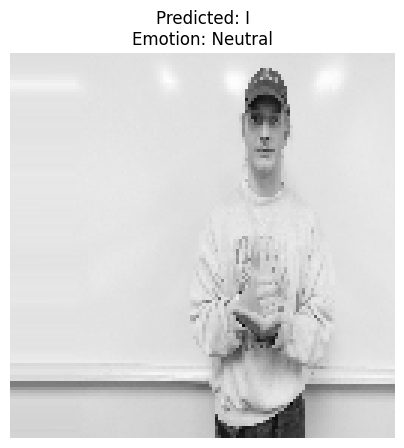

File: /content/drive/MyDrive/ASL recognition/help/aug_0_1026.jpeg, Predicted Label: I, Emotion: Neutral


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the emotion mapping function
def get_emotion_from_class(class_label):
    emotion_map = {
        'love': 'Positive, Affection',
        'thank-you': 'Positive, Gratitude',
        'sorry': 'Negative, Regret',
        'good': 'Positive, Happiness',
        'apple': 'Neutral',
        'can': 'Neutral',
        'want': 'Positive, Desire',
        'how': 'Neutral',
        'like': 'Neutral',
        'my': 'Neutral',
        'you': 'Neutral',
        'yes': 'Neutral',
        'get': 'Neutral',
        'have': 'Neutral',
        'help': 'Neutral',
        'I': 'Neutral'
    }
    return emotion_map.get(class_label, 'Unknown Emotion')

# Define the function for prediction and visualization
def predict_and_display_image(image_path, model, test_size=(128, 128)):
    # Class labels based on the provided mapping
    class_labels = ['I', 'apple', 'can', 'get', 'good', 'have', 'help', 'how', 'like', 'love', 'my', 'sorry', 'thank-you', 'want', 'yes', 'you']

    # Load the image
    img = load_img(image_path, target_size=test_size)  # Resize image to match model input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 128, 128, 3)

    # Predict the class using the model
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # Get the predicted label
    predicted_label = class_labels[predicted_class_idx]

    # Map the predicted label to an emotion
    predicted_emotion = get_emotion_from_class(predicted_label)

    # Display the image with the predicted label and emotion
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title(f"Predicted: {predicted_label}\nEmotion: {predicted_emotion}")
    plt.show()

    # Optionally, print the file path and predicted label/emotion
    print(f"File: {image_path}, Predicted Label: {predicted_label}, Emotion: {predicted_emotion}")

# Example usage
# Load the trained model
model = load_model("/content/drive/MyDrive/ASL recognition/model.h5")

# Provide the image path for the prediction
image_path = "/content/drive/MyDrive/ASL recognition/help/aug_0_1026.jpeg"  # Replace this with the image file path you want to predict

# Call the function
predict_and_display_image(image_path, model)
